## Load library and define some functions needed

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import datetime as dt

import json
import os.path
import gc

MODEL_FILE_NAME = 'model.txt'

## Read CSV data 

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
songs_df = pd.read_csv('data/songs.csv')
song_extra_info_df = pd.read_csv('data/song_extra_info.csv')
members_df = pd.read_csv('data/members.csv')

## Pre-process members.csv

In [3]:
def parse_str_to_date(date_str):
    # [format] yyyymmdd
    date_str = str(date_str)
    assert(isinstance(date_str, str))
    assert(len(date_str) == 8)
    
    year = int(date_str[:4])
    month = int(date_str[4:6])
    day = int(date_str[6:])
    
    return dt.date(year, month, day)
    
           
def transform_two_dates_to_days(row):
    start = parse_str_to_date(row['registration_init_time'])
    end = parse_str_to_date(row['expiration_date'])
    delta = end - start
    
    return delta.days


members_df['membership_days'] = members_df.apply(transform_two_dates_to_days, axis=1)
members_df.drop(['registration_init_time', 'expiration_date'], axis=1, inplace=True)
members_df.head(15)

,msno,city,bd,gender,registered_via,membership_days
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2223
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,725
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,457
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,1
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,138
5,zgPOEyUn5a/Fvuzb3m69ajzxjkbblVtObglW89FzLdo=,13,43,female,9,1921
6,Sw9AT8QoR4wWiNUqHZUH6g5ahzGUx4lo1g+Y3xE2f2M=,1,0,NaN,4,3
7,pg6bT2XZkSP1TDBy4qn3HBPY/HffKQ/bg8WIISQYBSY=,1,0,NaN,7,609
8,kfk1AdTNH2dNqF5LzIs4e0vwGPejw2jrnFjJlcYnEgk=,1,0,NaN,7,2454
9,tscijwx4dbEp0NXGl+iFtHJ8zrj+TkcMrduOQk9t+gE=,1,0,NaN,7,482


## Pre-process song_extra_info.csv

In [4]:
# reference http://isrc.ifpi.org/en/isrc-standard/code-syntax


def transform_isrc_to_year(isrc):
    if type(isrc) != str:
        return np.nan
    # this year 2017
    suffix = int(isrc[5:7])
    
    return 1900 + suffix if suffix > 17 else 2000 + suffix


def transform_isrc_to_country(isrc):
    if type(isrc) != str:
        return np.nan
    country = isrc[:2]
    
    return country


def transform_isrc_to_reg(isrc):
    if type(isrc) != str:
        return np.nan
    registration = isrc[2:5]
    
    return registration


def transfrom_isrc_to_desig(isrc):
    if type(isrc) != str:
        return np.nan
    designation = isrc[7:]
    
    return designation


song_extra_info_df['song_year'] = song_extra_info_df['isrc'].apply(transform_isrc_to_year)
song_extra_info_df['song_country'] = song_extra_info_df['isrc'].apply(transform_isrc_to_country)
song_extra_info_df['song_registration'] = song_extra_info_df['isrc'].apply(transform_isrc_to_reg)
song_extra_info_df['song_designation'] = song_extra_info_df['isrc'].apply(transfrom_isrc_to_desig)

song_extra_info_df.drop(['isrc', 'name'], axis=1, inplace=True)

song_extra_info_df.head(15)

,song_id,song_year,song_country,song_registration,song_designation
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,2012.0,TW,UM7,00043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,2016.0,QM,ZSY,00015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,2008.0,TW,A53,87303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,2013.0,US,SM1,01446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,2013.0,TW,A47,06001
5,QU8f6JR0/cwLGSqJX2XDVzFK0DxMaIUY15ALJXK7ziw=,2014.0,GB,AYE,00079
6,O1Oj4CmnZhbHl7oyBaHSpGeu5gvcSmUydY3Awmv3uxk=,2007.0,HK,UM7,04066
7,Tr5R61AuEkN8UelOCzu09ZwQi7/HmP9sQmxf9rFngIg=,2004.0,US,WD1,23930
8,ie9l12ZYXEaP4evrBBUvnNnZGdupHSX5NU+tEqB1SDg=,2002.0,HK,A61,00010
9,6mICNlckUVGuoK/XGC7bnxXf5s2ZnkpFHShaGL/zM2Y=,2010.0,TW,I43,00103


## Pre-process songs.csv

In [5]:
def parse_splitted_category_to_number(x):
    return 0if x is np.nan else len(str(x).split('|'))


songs_df['genre_count'] = songs_df['genre_ids'].apply(parse_splitted_category_to_number)
songs_df['composer_count'] = songs_df['composer'].apply(parse_splitted_category_to_number)
songs_df['lyricist_count'] = songs_df['lyricist'].apply(parse_splitted_category_to_number)
songs_df.head(15)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,genre_count,composer_count,lyricist_count
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,1,1,1
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,1,3,1
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0,1,0,0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0,1,1,1
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0,1,1,1
5,kKJ2JNU5h8rphyW21ovC+RZU+yEHPM+3w85J37p7vEQ=,235520,864|857|850|843,貴族精選,Joe Hisaishi,Hayao Miyazaki,17.0,4,1,1
6,N9vbanw7BSMoUgdfJlgX1aZPE1XZg8OS1wf88AQEcMc=,226220,458,伍佰 & China Blue,Jonathan Lee,NaN,3.0,1,1,0
7,GsCpr618xfveHYJdo+E5SybrpR906tsjLMeKyrCNw8s=,276793,465,光良 (Michael Wong),光良,彭資閔,3.0,1,1,1
8,oTi7oINPX+rxoGp+3O6llSltQTl80jDqHoULfRoLcG4=,228623,465,林俊傑 (JJ Lin),JJ Lin,Wu Qing Feng,3.0,1,1,1
9,btcG03OHY3GNKWccPP0auvtSbhxog/kllIIOx5grE/k=,232629,352|1995,Kodaline,Stephen Garrigan| Mark Prendergast| Vincent Ma...,Stephen Garrigan| Mark Prendergast| Vincent Ma...,52.0,2,5,5


## Merge all dataframes

In [6]:
songs_df = songs_df.merge(song_extra_info_df, on='song_id', how='left')

train_df = train_df.merge(songs_df, on='song_id', how='left')
test_df = test_df.merge(songs_df, on='song_id', how='left')

train_df = train_df.merge(members_df, on='msno', how='left')
test_df = test_df.merge(members_df, on='msno', how='left')

del members_df, song_extra_info_df
gc.collect()

train_df.info()
test_df.info()

for column in train_df.columns:
    if train_df[column].dtype == object:
        train_df[column] = train_df[column].astype('category')
for column in test_df.columns:
    if test_df[column].dtype == object:
        test_df[column] = test_df[column].astype('category')

x = train_df.drop(['target'], axis=1)
y = train_df['target'].values

x_test = test_df.drop(['id'], axis=1)
test_ids = test_df['id'].values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 24 columns):
msno                  object
song_id               object
source_system_tab     object
source_screen_name    object
source_type           object
target                int64
song_length           float64
genre_ids             object
artist_name           object
composer              object
lyricist              object
language              float64
genre_count           float64
composer_count        float64
lyricist_count        float64
song_year             float64
song_country          object
song_registration     object
song_designation      object
city                  int64
bd                    int64
gender                object
registered_via        int64
membership_days       int64
dtypes: float64(6), int64(5), object(13)
memory usage: 1.4+ GB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556790 entries, 0 to 2556789
Data columns (total 24 columns):
id            

## Correlation over all features (underconstruction...)

For categorical feature, need to numerize them.
Also, for all numeric features, it's necessary to be normalized.

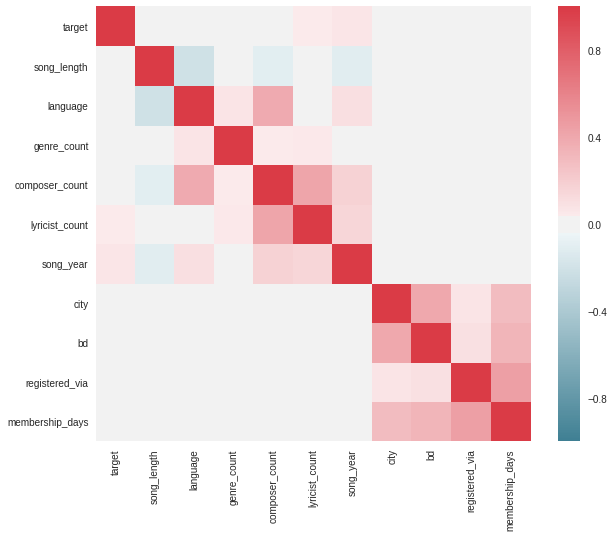

In [7]:
corr = train_df.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
sns.plt.show()

# LGBM training

In [8]:
train_set = lgb.Dataset(x, y)
valid_set = [train_set]

params = dict({
    'learning_rate': 0.1,
    'application': 'binary',
    'min_data_in_leaf': 4,
    'max_depth': 10,
    'num_leaves': 2 ** 10,
    'verbosity': 0,
    'metric': 'auc'
})

model = lgb.train(params, train_set=train_set, valid_sets=valid_set, num_boost_round=100, verbose_eval=5)
y_test = model.predict(x_test)

[5]	training's auc: 0.702587
[10]	training's auc: 0.717753
[15]	training's auc: 0.726803
[20]	training's auc: 0.733351
[25]	training's auc: 0.737748
[30]	training's auc: 0.741554
[35]	training's auc: 0.744764
[40]	training's auc: 0.747111
[45]	training's auc: 0.748899
[50]	training's auc: 0.749996
[55]	training's auc: 0.75144
[60]	training's auc: 0.753185
[65]	training's auc: 0.754674
[70]	training's auc: 0.756166
[75]	training's auc: 0.757681
[80]	training's auc: 0.758535
[85]	training's auc: 0.759723
[90]	training's auc: 0.760785
[95]	training's auc: 0.761805
[100]	training's auc: 0.763093


## Feature importances

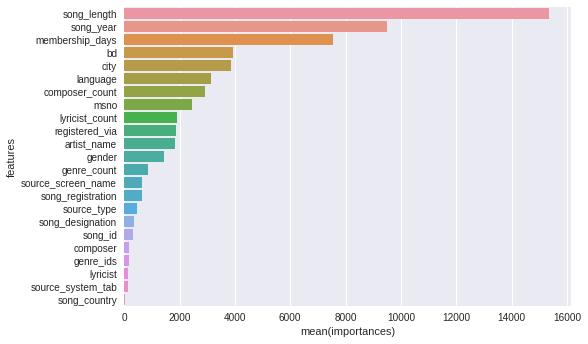

In [9]:
plot_df = pd.DataFrame({'features': train_df.columns[train_df.columns != 'target'],
                        'importances': model.feature_importance()})
plot_df = plot_df.sort_values('importances', ascending=False)

sns.barplot(x = plot_df.importances, y = plot_df.features)
sns.plt.show()

In [10]:
submission_df = pd.DataFrame()
submission_df['id'] = test_ids
submission_df['target'] = y_test
submission_df.to_csv('data/submission.csv', index=False)
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 2 columns):
id        int64
target    float64
dtypes: float64(1), int64(1)
memory usage: 39.0 MB
